#**Team :  Cloud Troopers**

## **Team Members:**



*   Amrutha Singh Balaji Singh - 013778583 
*   Anand Muralidhara - 013752622
*   Poorva Agarwal - 013770939
*   Snehal Yeole - 012548471 

## Data Exploration

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools as it
import collections as col
from wordcloud import WordCloud
import networkx as nx

from google.colab import drive
drive.mount('/content/drive')
path_data='/content/drive/My Drive/CMPE297/catalog.csv'
path_trans='/content/drive/My Drive/CMPE297/10000_transactions.csv'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Read in the data file and view the first few rows.

In [0]:
df = pd.read_csv(path_data, engine="python")
tdf = pd.read_csv(path_trans, engine="python")

df.head()

,prod_id,prod_name,department_id,price
0,36235,Organic Pure Extra Virgin Coconut Oil,13,12.02
1,24879,Pepperidge Farm® Goldfish Queso Fiesta Baked S...,19,4.17
2,37062,Pineapple Coconut Water Enhancer,7,8.77
3,7770,Quick-Tie Tall Kitchen Bags Gallon - 35 CT,17,3.56
4,14435,Bowl Blaster Toilet Bowl Cleaner,17,5.59


In [0]:
tdf.head()

,order_number,product_id,customer_id,product_name,department_id,price
0,2,33120,202279,Organic Egg Whites,16,5.33
1,5,48370,156122,Sensitive Toilet Paper,17,9.33
2,7,46802,142903,Pineapple Chunks,1,6.76
3,10,3464,135442,"Organic Butterhead (Boston, Butter, Bibb) Lettuce",4,9.00
4,10,25720,135442,Organic Sunchoke,4,10.06


## What is the distribution of prices, and how many things cost the same?
Let's assess which price amounts are assigned to products, and let's look at how many products are priced at each pricing point.

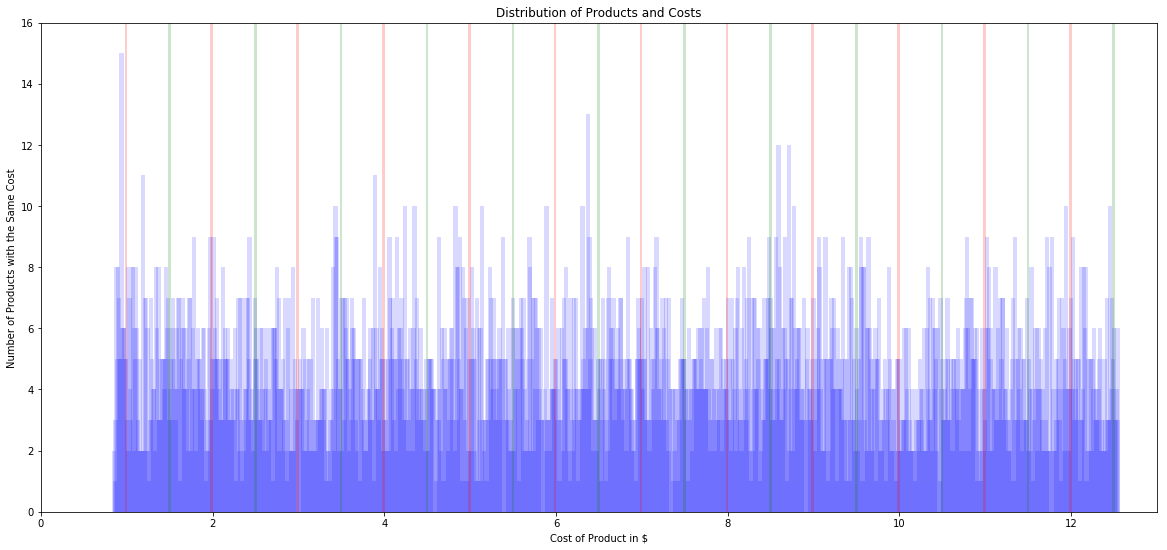

In [0]:
newPrice = []
for price in df['price']:
    newPrice.append(round(price, 2))

counted = Counter(newPrice)
index = np.arange(len(counted.keys()))
plt.figure(figsize=(20,9))

nns = []
for i in range(0, 12):
    nns.append(0.99 + 1*i)
fns = []
for i in range(1, 13):
    fns.append(0.497 + 1*i)
height = []
for i in range(12):
    height.append(16)
plt.bar(counted.keys(), counted.values(), align='center', color='b', width=0.05, alpha=0.15)
plt.bar(nns, height, color='r', align='center', width=0.03, alpha=0.2)
plt.bar(fns, height, color='g', align='center', width=0.03, alpha=0.2)

plt.axis([0, 13, 0, 16])
plt.xlabel('Cost of Product in $')
plt.ylabel('Number of Products with the Same Cost')
plt.title('Distribution of Products and Costs')
plt.show()

Green lines mark the \$\_.49 points along the cost axis. Red lines mark the \$\_.99 points. Notably, only the \$1.99 price tag has more products priced at 99 cents than at the adjacent 98 cents or rounded dollar amounts. This could suggest that **more profits could be made**, if [psychological pricing](https://en.wikipedia.org/wiki/Psychological_pricing) is used to motivate pricing models. Doing so would see more price tags set at the green or red lines.

No items are priced higher than \$12.55, meaning that this data source is possibly pulled from a distributor which does not sell bulk products, as these tend to be more expensive. Alternatively, the data source was simply limited to not display products with a higher cost.

While we're at it, let's see which items are being priced on the far left or far right of the range of prices, as well as the tall spike to the left of the first red line.

In [0]:
minPrice = min(newPrice)
minItems = df[df['price'] == minPrice][['department_id', 'prod_name']]
print("Cheapest Items, at $%.2f:" % minPrice)
for index, item in minItems.iterrows():
    print("%i - %s" % (item['department_id'], item['prod_name']))

maxPrice = max(newPrice)
maxItems = df[df['price'] == maxPrice][['department_id', 'prod_name']]
print("\nMost Expensive Items, at $%.2f:" % maxPrice)
for index, item in maxItems.iterrows():
    print("%i - %s" % (item['department_id'], item['prod_name']))

maxCount = max(counted, key=counted.get)
countItems = df[df['price'] == maxCount][['department_id', 'prod_name']]
print("\nItems Most Sharing the Same Cost, at $%.2f" % maxCount)
for index, item in countItems.iterrows():
    print("%i - %s" % (item['department_id'], item['prod_name']))

Cheapest Items, at $0.85:
7 - Chocolate Pu Erh Tea 16 ct
11 - Body Wash Pink Grapefruit Body Clear®

Most Expensive Items, at $12.55:
1 - Old Fashioned Vanilla Frozen Custard
16 - Original Strawberry Low Fat Yogurt
1 - Cheese Pizza In A Pocket Sandwich

Items Most Sharing the Same Cost, at $0.94
13 - Organic Ground Coriander
4 - Organic Pomegranate
19 - Mini Vanilla Chewy Chocolate Nougats
2 - Immunity Health, Gummy Bears
6 - Plum Sauce
19 - Bunny Ears Crisp Wafers in Milk Chocolate
19 - Dried Cherry Montmorency Tart
1 - All Natural Premium Cornish Hen
16 - Original Whipped Cream
7 - Organic Lemonade Cherry
1 - Pizzeria! Thin Margherita Pizza
3 - Gluten Free Blueberry Muffins
11 - Allergy Plus Congestion Grape Flavored Liquid
11 - Congestion Non-Drowsy Maximum Strength Phenylephrin HCl Tablets
4 - Butter Babies Potatoes


The above input is pretty interesting. The number prefixing each item is the department where that product comes from. We can see that the most expensive products share a common trait: they are **dairy products**. There seem to be less obvious correlations for the cheapest items, and for the items sharing the same cost. This is reasonable, however, as price tags do not necessarily infer any kind of relationship between products.

These numbers do raise a new question...

## How much money are we not making?
More items are priced at \$0.94 than any other. How many of these products are being sold? How much money could be saved if we sold these items for \$0.99 instead?

In [0]:
product094 = df[df['price'] == 0.94]
sold094 = len(product094)
actualRevenue=sold094*0.94

suggestedPrice=0.99
suggestedRevenue=0.99 * sold094
revenueDelta=suggestedRevenue-actualRevenue

print("Number of products sold at $0.94: \n%i" % sold094)
print("Profit if sold at $0.99: \n$%.2f" % revenueDelta)

Number of products sold at $0.94: 
15
Profit if sold at $0.99: 
$0.75


What if we rounded every price up to the nearest nine-cent value? For example, \$3.11 becomes \$3.19. How would the table of Distribution of Price and Costs change, and how much more money would be made?

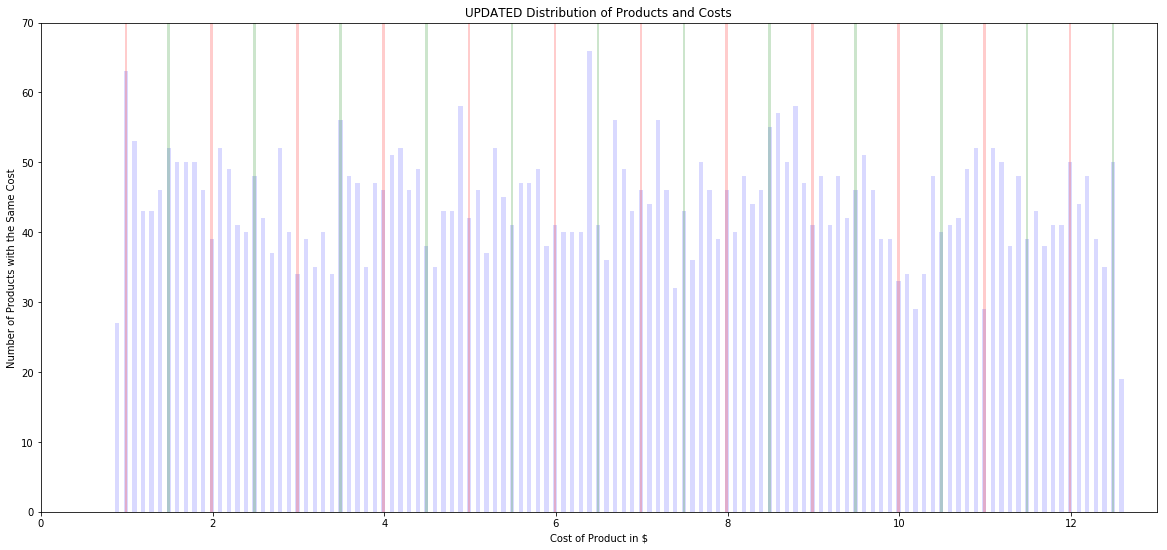

Amount of money made by rounding up to nearest 9 cents: $183.98
Amount of money made by selling every item once with current pricing model: $34504.31
Percentage profit gain by using 9-cent rounded model: 0.533%


In [0]:
def roundx(x):
    decimal = x - round(x,1)
    if decimal > 0:
        floor = round(x, 1)
        floor = floor + 0.09
        return floor
    else:
        ceil = round(x, 1)
        ceil = ceil - 0.01
        return ceil

updatedPrices = df.apply(lambda x: roundx(x['price']), axis=1).tolist()
newPrice = []
for price in updatedPrices:
    newPrice.append(round(price, 2))
counted=Counter(newPrice)
index = np.arange(len(counted.keys()))
plt.figure(figsize=(20,9))

nns = []
for i in range(0, 12):
    nns.append(0.99 + 1*i)
fns = []
for i in range(1, 13):
    fns.append(0.49 + 1*i)
height = []
for i in range(12):
    height.append(70)
plt.bar(counted.keys(), counted.values(), align='center', color='b', width=0.05, alpha=0.15)
plt.bar(nns, height, color='r', align='center', width=0.03, alpha=0.2)
plt.bar(fns, height, color='g', align='center', width=0.03, alpha=0.2)

plt.axis([0, 13, 0, 70])
plt.xlabel('Cost of Product in $')
plt.ylabel('Number of Products with the Same Cost')
plt.title('UPDATED Distribution of Products and Costs')
plt.show()

newRevenue = 0
currentModelRevenue = 0
i = 0
for base in df['price']:
    newRevenue = newRevenue + (updatedPrices[i] - base)
    currentModelRevenue = currentModelRevenue + base
    i = i + 1
print "Amount of money made by rounding up to nearest 9 cents: $%.2f" % newRevenue
print "Amount of money made by selling every item once with current pricing model: $%.2f" % currentModelRevenue
print "Percentage profit gain by using 9-cent rounded model: %.3f%%" % (newRevenue / currentModelRevenue * 100)

Even after rounding everything up to the nearest 9 cents, there is a surprising lack of emphasis along the red lines which mark 99 cents. The green lines marking 45 cents spike a bit heavier but are not huge either. Rounding prices to the left of these lines to be priced at these lines **might possibly increase revenue without decreasing sales.**

The \$184 value is the total amount of money involved in difference between the current pricing model and this 9-cent rounded model. In other words, if every product was sold once with this rounded model, an additional profit of \$184 would be made compared to selling every product once with the current model. This is a 0.533% increase in profits.

## What's with these "Departments"?
The catalog data contains information about the "department" that each cataloged product belongs to. The departments are stored simply as digits, which tells very little about the real significance of each deparment. This short distraction from business-value analysis, in order to put meaning to this category.



In [0]:
df = pd.read_csv(path_data, engine="python")

for i in range(1, 21):
    filtered = df[df['department_id'] == i]
    #Dep 1
    commonWords = Counter(" ".join(filtered['prod_name']).split()).most_common(13)
    actual = []
    stopWords = ["&", "Organic", "Food", "Free", "Natural", "in", "with"]
    for item in commonWords:
        if (item[0] not in stopWords):
            actual.append(item[0])
    actualStr = ', '.join(actual)
    print("DEPT %i: %s" % (i, actualStr))

DEPT 1: Cream, Ice, Chicken, Cheese, Frozen, Pizza, Chocolate, Vanilla, Crust, Bars, Sausage
DEPT 2: Lubricant, Condoms, Flavor, Original, White, Ultra, Premium, Thin, Grape, Cleanse
DEPT 3: Bread, Whole, Wheat, Grain, Muffins, Tortillas, Chocolate, English, Buns, Gluten, Rolls
DEPT 4: Salad, Red, Sweet, Baby, Sprouts, Tomatoes, Kale, Lettuce, Apples, Fresh, Squash, Pepper
DEPT 5: Ale, Sauvignon, Beer, Wine, Cabernet, Lager, IPA, Valley, Chardonnay, Whiskey, California, Scotch, Original
DEPT 6: Sauce, Mix, Noodles, Rice, Mild, Red, Enchilada, Seaweed, Style, Miso, Medium
DEPT 7: Tea, Juice, Water, Drink, Coffee, Sparkling, Orange, Blend, Fruit, Bags, 100%
DEPT 8: Cat, Dog, Chicken, Treats, Gravy, Litter, Salmon, Flavor, Turkey, Wet
DEPT 9: Pasta, Rice, Sauce, Cheese, Grain, Macaroni, Garlic, White, Spaghetti, Cheddar, Whole
DEPT 10: Brown, Ginger, Apricots, Beans, Basmati, Cranberry, Chunks, Rice, Crystallized
DEPT 11: Body, Soap, Hand, Wash, Liquid, Shampoo, Tablets, Oil, Vitamin, Gel

Based on the data above, we think the following are the category names for each of the departments. 

- Department 1: Frozen Food
- Department 2: Health / Pharmacy
- Department 3: Bread
- Department 4: Fresh Produce
- Department 5: Liquor
- Department 6: Ethnic Foods
- Department 7: Drinks
- Department 8: Pets
- Department 9: Pasta
- Department 10: ?????
- Department 11: Personal Care
- Department 12: Meat
- Department 13: Sauces
- Department 14: Breakfast
- Department 15: Canned Food
- Department 16: Diary
- Department 17: Cleaning
- Department 18: Baby
- Department 19: Sweets
- Department 20: Deli


## Are some departments more expensive than others?
From the Pricing discussion, we notice that two of the three most expensive items come from Department 1, which we now know sells Frozen Food. Could it be that frozen food is particularly expensive compared to the other departments?

Average cost of all items: $6.62


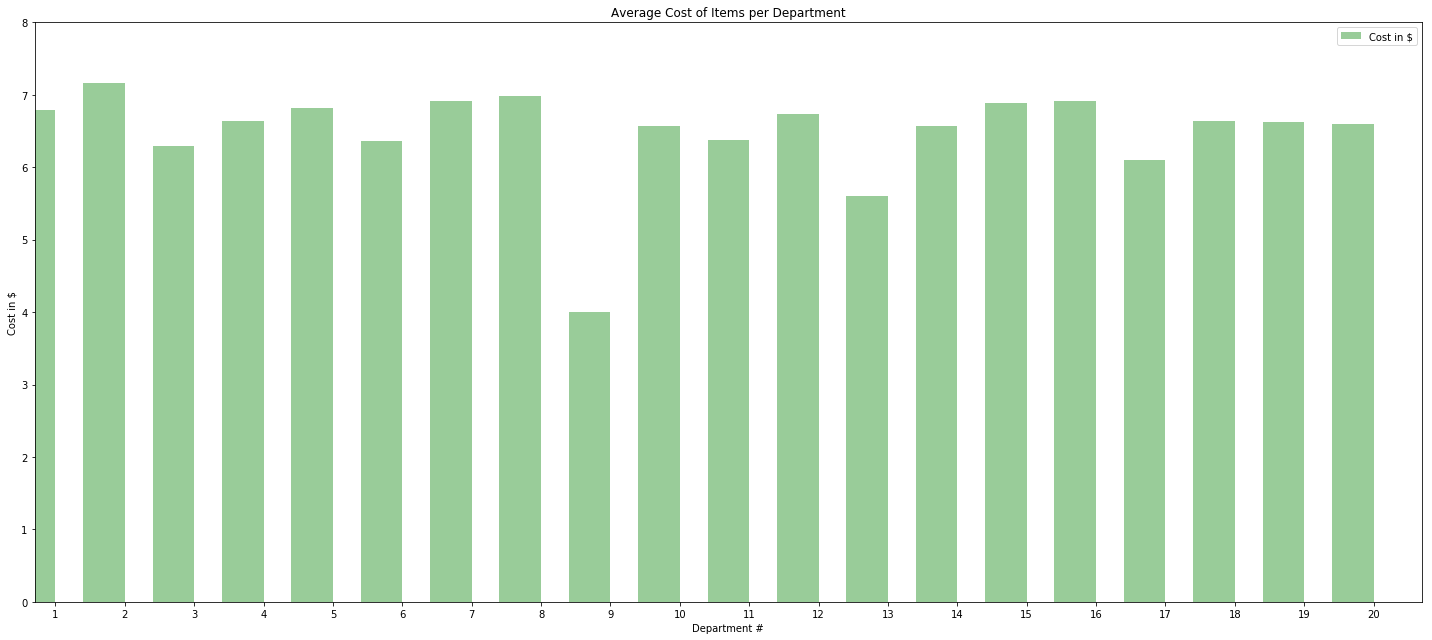

In [0]:
avgCost = df['price'].mean()
print("Average cost of all items: $%.2f" % avgCost)

costByID = df.groupby(['department_id', 'price']).sum().reset_index().groupby('department_id').mean()

groups = 21
plt.figure(figsize=(20,9))

index = np.arange(groups)
bar_width = 0.6

opacity = 0.4

rects = plt.bar(index, costByID['price'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Cost in $')

plt.xlabel('Department #')
plt.ylabel('Cost in $')
plt.title('Average Cost of Items per Department')

plt.xticks(index + bar_width / 2, range(0, 22))

plt.axis([1, 21, 0, 8])
plt.legend()
plt.tight_layout()
plt.show()

**Pasta (D9)** is particularly cheaper than others. This makes intuitive sense, since an individual package of pasta is rarely costed above $4. Given how the department is so out of line with the others, it might be wise to check that cheaply priced items from this department are supposed to be cheap; if not, this might be an opportunity to raise prices for these products.

It turns out that Department 1 is not the most expensive item. Instead, **Pharmacy (D2)** is a bit more expensive than the rest. This also makes intuitive sense, as the Pharmacy contains more premium products. Without having identified the department labeling beforehand, it would have been tempting to attribute these higher prices to generally more expensive products such as meat or gluten-free or organic options.

----------------------Shift to next presenter-------------------------------

## Are gluten free or organic products more expensive?
We've seen that some products are listed as "Gluten Free", "GF", or "Organic". Our observations about the expensive Department 3 make us hypothesize that many of these health-sensitive products are contained in this department. Overall, we can look at products labeled with the above words, and see if they are more expensive than other products.

592 organic/GF products
4629 other products
12.8% of products are organic/GF


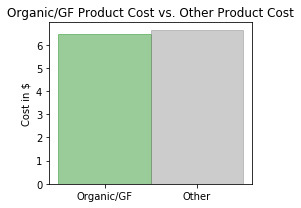

Organic is cheaper than global average by 2.1%.


In [0]:
# Get target, a DF of all organic and gluten free products
df['prod_name'] = df['prod_name'].str.lower()
organic = df[df['prod_name'].str.contains("organic")]
glutenFree = df[df['prod_name'].str.contains("gluten free")]
gF = df[df['prod_name'].str.contains("gf")]
frames = [organic, glutenFree, gF]
target = pd.concat(frames)

# Get others, a DF of all products which are not in target
ds1 = set([ tuple(line) for line in target.values.tolist()])
ds2 = set([ tuple(line) for line in df.values.tolist()])
others = pd.DataFrame(list(ds2.difference(ds1)))
others.columns = target.columns.tolist()

print("%i organic/GF products\n%i other products" % (len(target), len(others)))
percentHealth = len(target)*1.0/len(others)*100
print("%.1f%% of products are organic/GF" % percentHealth)

# Get average of all target products, and of all others products.
healthAvg = target['price'].mean()
otherAvg = others['price'].mean()

avgList = [healthAvg, otherAvg]

groups = 2

index = np.arange(groups)
bar_width = 1

opacity = 0.4
plt.figure(figsize=(4,3))

rects = plt.bar(index, avgList, bar_width, align='center', alpha=opacity)
rects[0].set_color('g')
rects[1].set_color('grey')

plt.ylabel('Cost in $')
plt.title('Organic/GF Product Cost vs. Other Product Cost')
labels = ["Organic/GF", "Other"]
plt.xticks(index, labels)

plt.tight_layout()
plt.show()

organicPercentage = (1 - healthAvg*1.0 / avgCost) * 100
print("Organic is cheaper than global average by %.1f%%." % organicPercentage)

Turns out, eater-sensitive products are cheaper than the average non-sensitive product, and cheaper than the global average by 2.1%! This could be a great **advertising point**, to encourage customers to make healthy choices!

## Which departments carry the most organic products? Which ones sell?
We don't want to carry products that don't sell well. We can combine transaction and catalog data to find how many organic products are offered and sold in each department.

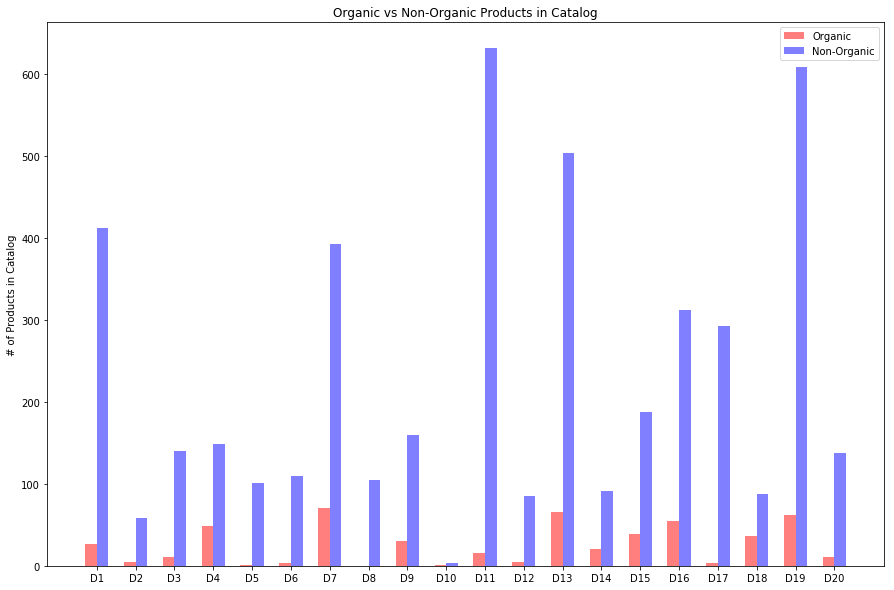

In [0]:
df = pd.read_csv(path_data, engine="python")

df['prod_name'] = df['prod_name'].str.lower()

#ORGANIC COUNT PER DEPT
filteredOrg = df[df['prod_name'].str.contains("organic")]

organicDeptTotal = []
for depts in range (1, 21):
    tempDept = filteredOrg[filteredOrg['department_id'] == depts]
    totalCount = len(tempDept)
    organicDeptTotal.append(totalCount)

#NON ORGANIC COUNT PER DEPT
ds1 = set([ tuple(line) for line in filteredOrg.values.tolist()])
ds2 = set([ tuple(line) for line in df.values.tolist()])
filteredNonOrg = pd.DataFrame(list(ds2.difference(ds1)))
filteredNonOrg.columns = filteredOrg.columns.tolist()

nonOrganicDeptTotal = []
for depts in range (1, 21):
    tempDept = filteredNonOrg[filteredNonOrg['department_id'] == depts]
    totalCount = len(tempDept)
    nonOrganicDeptTotal.append(totalCount)

#bar graph

chikkin = 20
width = 0.3
ind = np.arange(chikkin)

fig, ax = plt.subplots(1, 1, figsize=(15,10))

chikkin1 = ax.bar(ind, organicDeptTotal, align = 'center', color = 'r', alpha = 0.5, width = 0.3)
chikkin2 = ax.bar(ind+width, nonOrganicDeptTotal, align = 'center', color = 'b', alpha = 0.5, width = 0.3)

#labels

ax.set_ylabel('# of Products in Catalog')
ax.set_title('Organic vs Non-Organic Products in Catalog')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('D1', 'D2', 'D3', 'D4', 'D5', 'D6','D7','D8', 'D9',
                    'D10', 'D11','D12', 'D13', 'D14', 'D15', 'D16','D17','D18', 'D19', 'D20'))

ax.legend((chikkin1[0], chikkin2[0]), ('Organic', 'Non-Organic'))

plt.show()

The store’s catalog is sorted by department and ‘organic vs non-organic’ products. 

The top 7 departments with the most organic products cataloged are (in descending order): 
1. Drinks [D7]
2. Sauces [D13]
3. Sweets [D19]
4. Dairy [D16]
5. Fresh Produce [D4]
6. Canned Food [D15]
7. Baby [D18]

The 7 departments with the least organic products cataloged are (in ascending order): 
1. Pets [D8]
2. Liquor [D5]
3. Cleaning [D17]
4. Ethnic Foods [D6]
5. Health/Pharmacy [D2]
6. Meat [D12]
7. Deli [D20]

It would be helpful to know whether these organic options actually sell, and how they compare to non-organic products of the same kind.

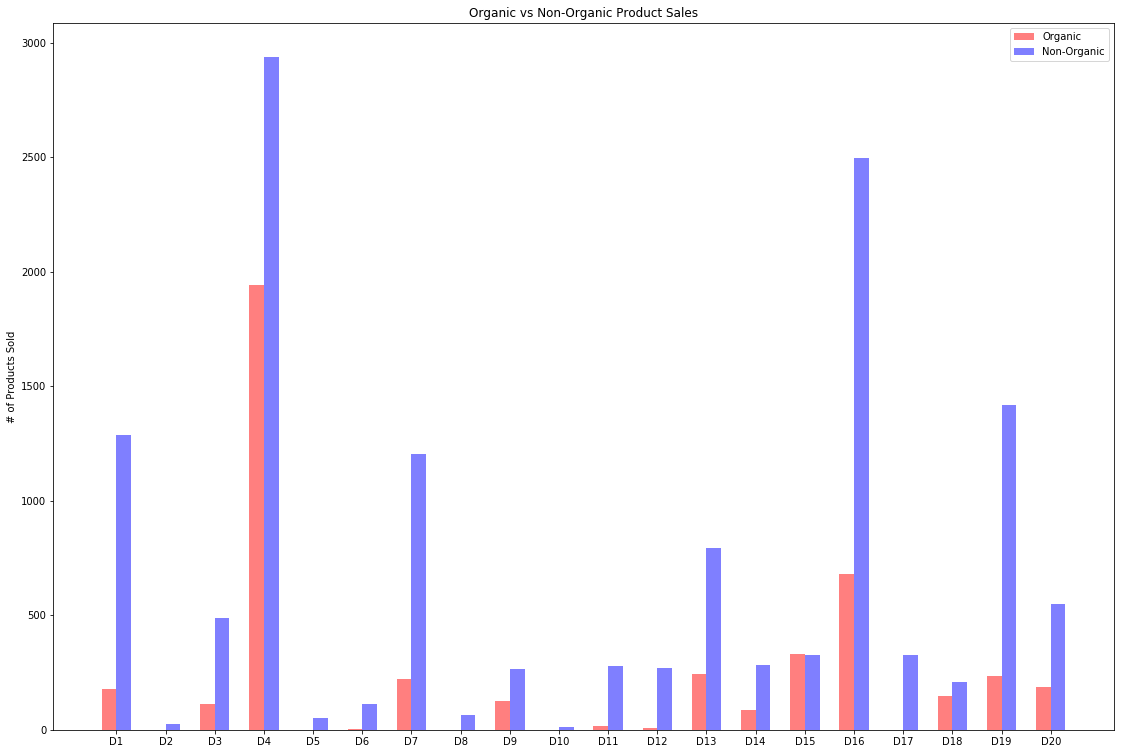

In [0]:
tdf['product_name'] = tdf['product_name'].str.lower()

#ORGANIC COUNT PER DEPT
filteredOrg = tdf[tdf['product_name'].str.contains("organic")]

organicDeptTotal = []
for depts in range (1, 21):
    tempDept = filteredOrg[filteredOrg['department_id'] == depts]
    totalCount = len(tempDept)
    organicDeptTotal.append(totalCount)

#NON ORGANIC COUNT PER DEPT
ds1 = set([ tuple(line) for line in filteredOrg.values.tolist()])
ds2 = set([ tuple(line) for line in tdf.values.tolist()])
filteredNonOrg = pd.DataFrame(list(ds2.difference(ds1)))
filteredNonOrg.columns = filteredOrg.columns.tolist()

nonOrganicDeptTotal = []
for depts in range (1, 21):
    tempDept = filteredNonOrg[filteredNonOrg['department_id'] == depts]
    totalCount = len(tempDept)
    nonOrganicDeptTotal.append(totalCount)

#bar graph

chikkin = 20
width = 0.3
ind = np.arange(chikkin)

fig, ax = plt.subplots(1, 1, figsize=(19,13))

chikkin1 = ax.bar(ind, organicDeptTotal, align = 'center', color = 'r', alpha = 0.5, width = 0.3)
chikkin2 = ax.bar(ind+width, nonOrganicDeptTotal, align = 'center', color = 'b', alpha = 0.5, width = 0.3)

#labels

ax.set_ylabel('# of Products Sold')
ax.set_title('Organic vs Non-Organic Product Sales')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('D1', 'D2', 'D3', 'D4', 'D5', 'D6','D7','D8', 'D9',
                    'D10', 'D11','D12', 'D13', 'D14', 'D15', 'D16','D17','D18', 'D19', 'D20'))

ax.legend((chikkin1[0], chikkin2[0]), ('Organic', 'Non-Organic'))

plt.show()

In this graph, we notice that a very low volume the aforementioned pharmaceutical products are sold overall compared to other products. There may be a few explanations for this.
- Customers might not need to purchase pharmaceutical products frequently, so **there is no reason to buy in large volumes**.
- It was observed previously that the pharmaceutical items are on average more expensive than any other product type. It may be the case that these products are too expensive, so potential customers are going elsewhere to buy. It might be beneficial to **consider the effects of reducing the price** of some items in this department.
- The data suggests that the customer might not see this company as a pharmaceutical one, especially compared to the amount of food products sold. It might be that the company's **identity is not in pharmaceutical** products. Remediating options include a marketing effort to communicate the company's commitment to pharmaceuticals, and the termination or reductionof pharmaceutical options.

We notice no major inconsistencies in the amount of organic product options compared to the volume of organic products purchased, particularly compared to the non-organic options. On the other hand, we do notice some strong positive correlations which ought to be kept in mind. In particular, Department 18 which carries baby products offers many organic options, and also boasts many organic purchases, nearly a half split with non-organic. This suggests that **parents value organic products for their young children**. This observation could motivate promotional content or marketing.

We notice an interesting trend in Department 15 selling canned food. Though there is a limited variety of organic options compared to non-organic, Department 15 is the only department where more organic items are sold than non-organic. This might suggest that offering a **larger variety of organic options** would be beneficial. It might also be revealing of a **customer sensitivity to healthy preserved foods**, which might be harnessed through targetted marketing.

#### We can see that **D4 (Fresh Produce)** has the highest sales for organic products compared to other departments. This shows that Customers tend to buy fresh produce in organic rather than non-organic. 

## What are the most popular elements of products?
There is lots of transaction data which records what customers buy. Of all the things they buy, which words describe the most popular products?

In [0]:
commonWords = Counter(" ".join(tdf["product_name"]).split()).most_common(100)
def generateWordCloudString(tuples):
    wcString = ""
    for t in tuples:
        t_lower = t[0].lower()
        for count in range(t[1]/10):
            wcString = " " + t_lower + wcString
    return wcString

wcWords = generateWordCloudString(commonWords)
# exportWCText(wcWords)

def exportWCText(wcString):
    with open("Output.txt", "w") as text_file:
        text_file.write("{0}".format(wcWords))
#     Word cloud generated with: https://www.jasondavies.com/wordcloud/

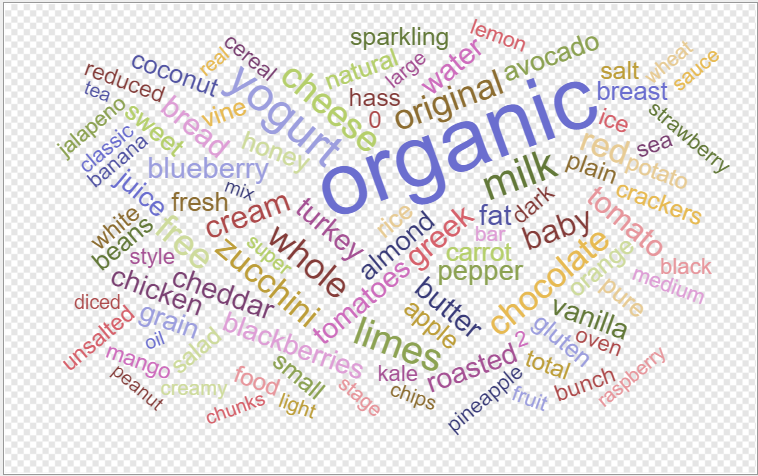



We can see that organic products are highly valued by customers who shop here. Any of the following could be at play as a cause or an effect of this observation:
- As previously observed, organic products are cheap here.
- There is a large selection of produce.
- The store's brand is one well-known for healthy products.

## Who are the best customers? Why do they keep coming back?
Transaction data also keeps track of who buys what. Is there anything in common with what the most frequent shoppers buy that might keep them coming back? Or might there be anything we could learn from those customers that have only shopped once?

In [0]:
commonCust = Counter(tdf["customer_id"]).most_common(100)
for i in range(10):
    print commonCust[i][0]

6409
60694
100330
5360
127427
168651
87634
127525
34200
199862


Each customer is assigned an id number unique to them. When they make a purchase, their activity is logged along with their ID. We can use this ID to analyze these frequent shoppers' purchases. 

In [0]:
productPool = []
for custID in commonCust:
    custProductsDF = tdf[tdf['customer_id'] == custID[0]]
    custProducts = custProductsDF['product_name'].tolist()
    productPool.extend(custProducts)

commonProduct = Counter(" ".join(productPool).split()).most_common(100)
    
wcProdWords = generateWordCloudString(commonProduct)
# exportWCText(wcProdWords)

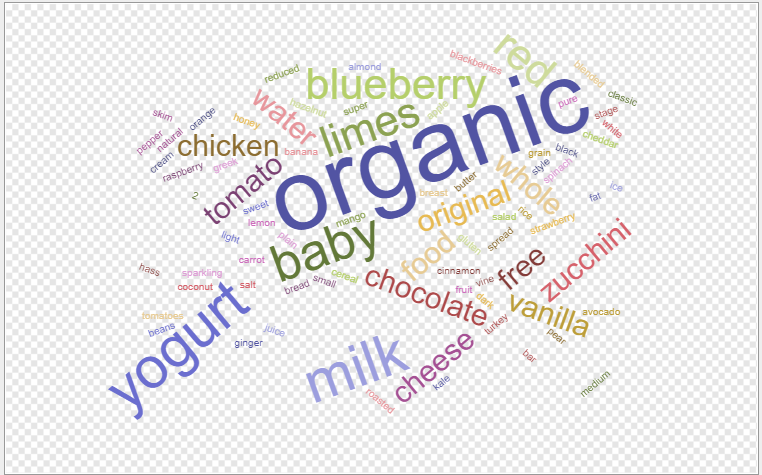

These look very similar to the most popular products overall. Are there any words or products that regular customers purchase that are not in the pool of most popular products?

In [0]:
allWords = wcWords.split()
popWords = wcProdWords.split()

def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

popOnly = diff(popWords, allWords)
for word in popOnly:
    print word

raspberry
spread
blended
2
cinnamon
ginger
spinach,
skim
pear
hazelnut


Some of these words seem to be incomplete product names. Let's see which products these words are actually referring to.

In [0]:
spread = set([s for s in productPool if "Spread" in s])
blended = set([s for s in productPool if "Blended" in s])
two = set([s for s in productPool if " 2 " in s])
skim = set([s for s in productPool if "Skim" in s])
spinach = set([s for s in productPool if "Spinach," in s])

foodLists = [spread, blended, two, skim, spinach]
specificFoods = []
for l in foodLists:
    for item in l:
        print item

peach mango stage 2 baby food
baby food stage 2 blueberry pear & purple carrot
organic stage 2 winter squash baby food puree


Looking through this list reveals at least the following observations:
- Baby Food in many of its various forms are valued products. The data supports our previous supposition that **parents are concerned about their little ones eating well early in life.** This detail might motivate promotional events, sales, or advertising for baby food products.
- "Hazelnut Spread With Skim Milk & Cocoa" is a valued product, as it represents two popular products, namely Hazelnut and Spread, in one.
- Blended Yogurt is a valued product.
These seem to be more specialty items compared to general products like chicken or milk, but something about the price or quality of these items **keep customers coming back**. 

Distributors should consider making sure these products stay available. These products are prime targets for putting on sale to draw in new regular customers and improve customer satisfaction.

## What do customers buy together?
Customers often buy multiple products at once. Sometimes, they buy products because those items go together. For example, if a customer buys lunch meat, we could reasonably expect them to purchase bread, mustard, or lettuce on the same visit. If we know what items customers buy together, we can organize marketing, store layouts, and more to increase sales and improve the customer experience.

To do this, we will analyze all combinations of products which are bought together to find which pairs of two are purchased more often.

In [0]:
tdf = pd.read_csv(path_trans, engine="python")
listy = {}
top = [[0,"",[]],[0,"",[]],[0,"",[]],[0,"",[]],[0,"",[]]]
for i in range(0,17955):
    if tdf.iloc[i].product_name not in listy:
        listy[""+tdf.iloc[i].product_name] = 0
    listy[""+tdf.iloc[i].product_name] = listy[""+tdf.iloc[i].product_name] + 1
for key in listy:
    for i in range(0,5):
        if listy[key]>top[i][0]:
            #shift
            for a in range(i+2,5):
                top[a][0] = top[a-1][0]
            top[i][1] = key
            top[i][0] = listy[key]
            break  
# for key in listy:
#     print key+": "+str(listy[key])
topItems = []
for item in top:
    topItems.append(item[1])
print(', '.join(topItems))

Limes, Organic Zucchini, Small Hass Avocado, Frozen Organic Blueberries, Smok Cured Turkey Bacon


At this point, we are partway through generating a network that displays the relationships between products. For transparency, the above output is a list of the five items which are most often bought alongside other items.

In [0]:
# coding: utf-8

# In[ ]:

import pandas as pd
import itertools as it
import collections as col
import networkx as nx
import matplotlib.pyplot as plt

count = col.Counter()
combos = []
# NOTE! Previously called "tdf" is now called "df"!
df = pd.read_csv(path_trans, engine="python")
listy = []
#make a list
for i in range(1,17955):
    for a in range(0,len(df[df.order_number==df.iloc[i].order_number])):
        listy.append((df[df.order_number==df.iloc[i].order_number]).iloc[a].product_name)
    combos = combos + list(it.combinations(listy,2))
    listy = []
#print count(combos)

for pair in combos:
    count[pair] = count[pair]+1
common = count.most_common()[0:12]
# print common
ids = {}
i=0
for cell in common:
    if cell[0][0] not in ids:
        ids[cell[0][0]] = i
        i = i + 1
for cell in common:
    if cell[0][1] not in ids:
        ids[cell[0][1]] = i
        i = i + 1
#print ids

#networkx library
G = nx.Graph()

for cell in common:
    #G.add_node(cell[0][0])
    #G.add_node(cell[0][1])
    G.add_edge(cell[0][0],cell[0][1],color='r',weight=cell[1]*0.05)

pos = nx.spring_layout(G,k=0.1,iterations=3)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

plt.figure(50,figsize=(10,8)) 
# nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)
# nx.draw_networkx_labels(G,pos)
# plt.show()

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

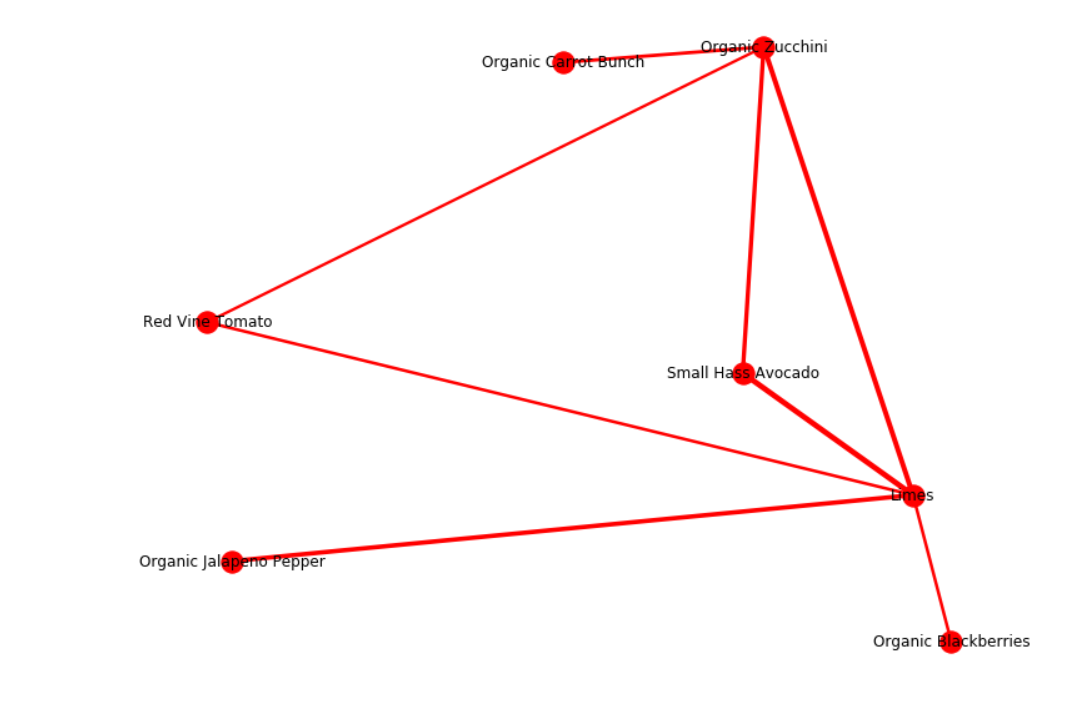

This image represents relationships between products. Each circle represents a product. Each line between two products represents the fact that customers who bought one item also bought the other in the same transaction. The thicker the line, the more customers who bought the same two products, and the stronger the relationship is between the products.

The relationship between **limes and organic zucchini** is the strongest, with 127 customers buying both at once.

These relationship graphs can help inform the following and more:
- Store layouts, so that related products are placed close to each other.
- Marketing, so that advertising of one product can be targetted to customers who purchase a related product.
- Customer trends, so that popular "go-together" products can be identified early.
- Gaps in customer understanding, such that customers can be informed of products which have an expected relationship that has not been manifested.

# Summary
- Graphs of pricing show a lack of psychological pricing. A distributor might consider rounding prices up (or down in some cases) in order to maximize profits and increase sales.
- The most expensive products available are dairy products.
- Many products from Department 9 (pasta) are priced around \$4. A distributor might ensure that this is correct and that potential profits are not being lost from products in this department.
- Pharmaceutical products in Department 2 are the most expensive on average and are sold in the least quantities. This might suggest a lack of demand, an overpriced product, or a misconstrued company image.
- On average, organic and gluten free products are 2% cheaper than the average product. A distributor might consider using this as point in advertising.
- Parents' buying habits reveal a desire to provide organic products for their young children. Having options available, communicating them to customers, and advertising these products might increase profits or customer satisfaction.
- Products such as spinach, ginger, and pear are purchased more frequently by returning customers than by the average customer. Distributor might consider ensuring the availability of these products, making them easily accessible, or providing promotions.
- If a customer is buying avocado, they will likely also purchase zucchini or lime.